In [2]:
# ------------------------------------------#
#        Expt 5: Perform a battery of negative inference tests from a single script and plot results, save metadata    
# ------------------------------------------#

Threads.nthreads()
begin
    using LinearAlgebra 
    using Plots
    using FFTW
    using FileIO
    using JLD2
    using DiffEqFlux
    using OrdinaryDiffEq
    using BlockArrays
    using LaTeXStrings
    using SparseArrays
    using BSON
    using Distances
    using DifferentialEquations
    using Optimization
    using OptimizationPolyalgorithms
    using Zygote
    using OptimizationOptimJL
    using OptimizationOptimisers
    using DiffEqSensitivity
    using DelimitedFiles
    using HDF5
    using Plots
    using InvertedIndices
    using Statistics
end 

┌ Warning: Error requiring `LazyArrays` from `DistributionsAD`
│   exception =
│    LoadError: UndefVarError: ValueSupport not defined
│    Stacktrace:
│      [1] top-level scope
│        @ ~/.julia/packages/DistributionsAD/GGe2E/ext/DistributionsADLazyArraysExt.jl:15
│      [2] include(mod::Module, _path::String)
│        @ Base ./Base.jl:419
│      [3] include(x::String)
│        @ DistributionsAD ~/.julia/packages/DistributionsAD/GGe2E/src/DistributionsAD.jl:1
│      [4] top-level scope
│        @ ~/.julia/packages/Requires/Z8rfN/src/Requires.jl:40
│      [5] eval
│        @ ./boot.jl:368 [inlined]
│      [6] eval
│        @ ~/.julia/packages/DistributionsAD/GGe2E/src/DistributionsAD.jl:1 [inlined]
│      [7] (::DistributionsAD.var"#398#411")()
│        @ DistributionsAD ~/.julia/packages/Requires/Z8rfN/src/require.jl:101
│      [8] macro expansion
│        @ timing.jl:382 [inlined]
│      [9] err(f::Any, listener::Module, modname::String, file::String, line::Any)
│        @ Require

In [190]:
using Statistics

In [3]:
filename = "/home/tschala/research/LANL/case1_1_1D_waveforms_results.h5"
file = h5open(filename, "r")
# Read the dataset
data1d = read(file["data"])

# Close the file
close(file)

In [4]:
filename

"/home/tschala/research/LANL/case1_1_1D_waveforms_results.h5"

In [5]:
println("Size of 1D data matrix:",size(data1d))
println("Shape: [timesteps,spatial locations,waveforms,variables]")

# note that some elements in space a duplicate
# the real spatial size is 100

Size of 1D data matrix:(300, 110, 47, 4)
Shape: [timesteps,spatial locations,waveforms,variables]


In [6]:
# remove duplicate data (both ends of a segment are saved)
data1d_fix = data1d[200:end,Not(11:11:end),:,:];
# remove the unphysical peaks, just replace with linear interpolation
data1d_fix[:,41,:,1] = (data1d_fix[:,40,:,1] + data1d_fix[:,42,:,1])/2;
data1d_fix[:,61,:,1] = (data1d_fix[:,60,:,1] + data1d_fix[:,62,:,1])/2;

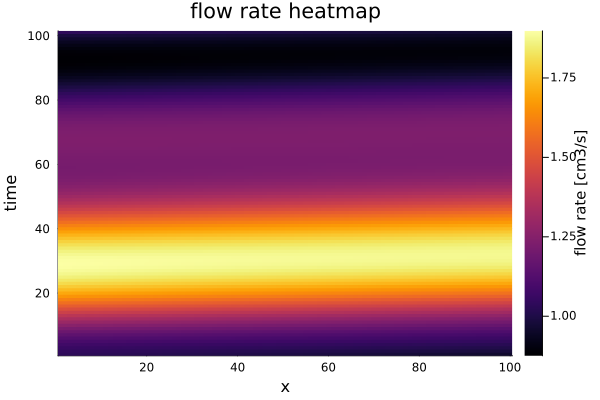

In [46]:
heatmap(data1d_fix[:,:,20,1], title="flow rate heatmap", cbar_title = "flow rate [cm3/s]")
xlabel!("x")
ylabel!("time")


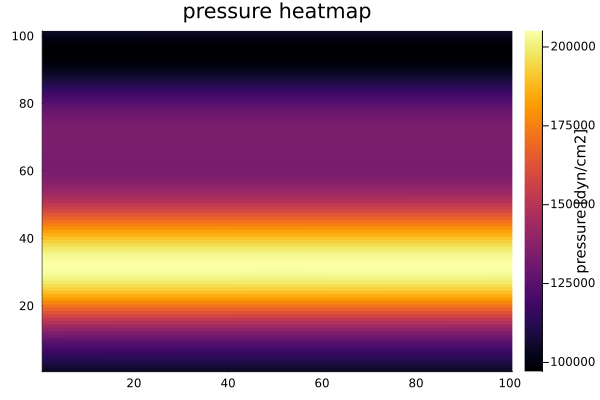

In [8]:
heatmap(data1d_fix[1:end,:,20,2], title="pressure heatmap", cbar_title = "pressure [dyn/cm2]")

In [236]:
begin
    global dt = 0.01                     # time step
    global T = 1                      # total time
    global tsteps = 0.0:dt:T             # discretized time dimension
    global tspan = (0,T)                 # end points of time integration for ODEProbem

    global train_maxiters = 5         # number of iterations of learning
    global learning_rate  = 0.005         # learning rate , currently using PolyOpt default (0.1)


end

0.005

In [114]:
waveforms = 5

5

In [115]:
u0 = data1d_fix[1,:,1:waveforms,1];
u01 = data1d_fix[1,:,1,1];

In [116]:
size(u01)

(100,)

In [117]:
ytrain2 = data1d_fix[:,:,1:waveforms,1];
ytrain21 = data1d_fix[:,:,1,1];


In [118]:
size(ytrain21)

(101, 100)

In [264]:
N = size(u01,1)
# NN embedded in PDE for Differential programming
ann = Chain(
            Dense(N,10,tanh),
            Dense(10,10,tanh),
            Dense(10,10,tanh),
            Dense(10,N));

In [265]:
# flatten parameters in NN for learning.                
p, re = Flux.destructure(ann);
ps = deepcopy(p)
p_size = size(p,1);
println("Number of parameters in neural network: $p_size"); 

Number of parameters in neural network: 2330


In [266]:
function learn_1DBlood(u,p,t)
    Φ = re(p) # restructure flattened parameter vector into NN architecture.
    return  Φ(u) #- 3.0/2.0 .* u .* (∂x1 *u) - 1.0 ./ 6.0 .* (∂x3 * u) # ϕ(u) is the NN taking u and predicting the missing first term
end 

learn_1DBlood (generic function with 1 method)

In [267]:
#define learning problem.
learn_1DBlood_prob(u01,tspan) = ODEProblem(learn_1DBlood, u01, tspan, p)

learn_1DBlood_prob (generic function with 1 method)

In [268]:
ode_solver = "Tsit5"
output_dir = "/home/tschala/research/LANL/testNODE"
working_dir = output_dir
# calculate and save the untrained solution 
begin 
    learn_1DBlood_prob_untrained(u01,tspan) = ODEProblem(learn_1DBlood, u01, tspan,p)     # p changes after training   
    if ode_solver == "Tsit5"
        sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Tsit5(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
    elseif ode_solver == "RK4"
        sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),RK4(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
    elseif ode_solver == "Rosenbrock23"
        sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Rosenbrock23(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
    end
    save_object(output_dir*"/sol_learn_testNODE_untrained.jld2",sol_learn_1DBlood_untrained)
    println("saved untrained solution")
end 

saved untrained solution


In [269]:
prob = ODEProblem(learn_1DBlood, u01, tspan, p);
function predict(θ,prob)
    if ode_solver == "Tsit5"
        Array(solve(prob,Tsit5(),p=θ,dt=dt,saveat=dt))
    elseif ode_solver == "RK4"
        Array(solve(prob,RK4(),p=θ,dt=dt,saveat=dt))
    elseif ode_solver == "Rosenbrock23"
        Array(solve(prob,Rosenbrock23(),p=θ,dt=dt,saveat=dt))
    end
end 

predict (generic function with 1 method)

In [270]:
function loss(θ, ytrain21, prob)
    pred = predict(θ, prob)
    l = sum(abs2, pred - ytrain21')
    return l, pred
end


l , pred = loss(ps,ytrain21,prob)

# training optimizer definition
adtype = Optimization.AutoZygote() ;
optf = Optimization.OptimizationFunction((x,p)->loss(x,ytrain21,prob),adtype) ;

In [271]:
path_checkpoint=nothing
optimizer_choice1 = "ADAM"
optimizer_choice2 = "BFGS"

"BFGS"

In [272]:
path_to_working_directory="/home/tschala/research/LANL/juliaDiffProgExample/"

include("$path_to_working_directory/src/numerical_derivatives.jl");
include("$path_to_working_directory/src/train_utils.jl");

In [273]:
# process user choices

if !isdir(working_dir)
    mkdir(working_dir)
end
output_dir = working_dir*"/output/"
cd(working_dir) #switch to working directory
if !isdir(output_dir)
    mkdir(output_dir)
end
println("optimizer 1 is $optimizer_choice1")
if !isnothing(optimizer_choice2)
    println("optimizer 2 is $optimizer_choice2 optimizer")
end

println("ODE Time integrator selected:", ode_solver)


optimizer 1 is ADAM
optimizer 2 is BFGS optimizer
ODE Time integrator selected:Tsit5


In [274]:
# # # Calculate and store normalization parameters for each initial condition
# # normalization_params = []
# # for i in 1:size(ytrain2, 3)
# #     mean_y = mean(ytrain2[:,:,i])
# #     std_y = std(ytrain2[:,:,i])
# #     push!(normalization_params, (mean_y, std_y))
# # end

# # ytrain_norm = similar(ytrain2)

# # for i in 1:size(ytrain2, 3)
# #     mean_y, std_y = normalization_params[i]
# #     ytrain_norm[:,:,i] .= (ytrain2[:,:,i] .- mean_y) ./ std_y
# # end


# # Calculate and store normalization parameters for each initial condition
# normalization_params = []
# for i in 1:size(ytrain2, 3)
#     min_y = minimum(ytrain2[:,:,i])
#     max_y = maximum(ytrain2[:,:,i])
#     push!(normalization_params, (min_y, max_y))
# end

# ytrain_norm = similar(ytrain2)

# for i in 1:size(ytrain2, 3)
#     min_y, max_y = normalization_params[i]
#     ytrain_norm[:,:,i] = (ytrain2[:,:,i] .- min_y) ./ (max_y - min_y)
# end


In [275]:
# restart training from previaous checkpoint if it exists, else start 
# fresh training.
if !isnothing(path_checkpoint)
    checkpoint_exists = isfile(path_checkpoint)
    if checkpoint_exists
        println("Checkpoint exists!")
        ckpt_restart = jldopen(path_checkpoint,"r")
        res1 = ckpt_restart["ckpt"]
        uinit = copy(res1.u)
    else
        println("ckpt path given, but no file found!")
    end
else
    uinit = deepcopy(ps)
    println("Fresh training initialized")
end

Fresh training initialized


In [276]:
n_epochs = 50
list_loss_train = []
for j in 1:n_epochs
    loss_tot = 0.0
    for i in 1:size(ytrain2,3)
        prob = ODEProblem(learn_1DBlood, u0[:,i], tspan, uinit);
#         l , pred = loss(uinit,ytrain2[:,:,i],prob)
        optf = Optimization.OptimizationFunction((x,p)->loss(x,ytrain2[:,:,i],prob),adtype) ;
        println("Start training epoch ",j)
        println("Using $optimizer_choice1 optimizer")
        println("Sum of params:", sum(uinit))
        

        if j==1 && i ==1
            optimizer_choice1 = "ADAM"
            uinit = train_loop(uinit,adtype,optf,train_maxiters,learning_rate,optimizer_choice1)
        else
            optimizer_choice1 = "ADAM"
            uinit = train_loop(uinit,adtype,optf,train_maxiters,learning_rate,optimizer_choice1)
        end
        println("Sum of params:", sum(uinit))
        if !isnothing(optimizer_choice2)
            println("Switching to $optimizer_choice2 optimizer")
            
            uinit = train_loop(uinit,adtype,optf,train_maxiters*5,learning_rate,optimizer_choice2)

            println("Sum of params:", sum(uinit))


            println("Completed training:" ,i)
        else
            println("Completed training:" ,i)
        end

        prob = ODEProblem(learn_1DBlood, u0[:,i], tspan, uinit);
        l , pred = loss(uinit,ytrain2[:,:,i],prob)
        loss_tot = loss_tot + l
        println("Final BFGS loss:",l)

    end
    
    push!(list_loss_train, loss_tot/size(ytrain2,3))
    println("Epoch ", j, " mean loss:", loss_tot/size(ytrain2,3))
end

Start training epoch 1
Using ADAM optimizer
Sum of params:10.616195
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 911.3292687472645
Iteration: 2 || Loss: 788.7449813533993
Iteration: 3 || Loss: 757.3569883340032
Iteration: 4 || Loss: 777.689598030698
Iteration: 5 || Loss: 737.1282442326637
Iteration: 6 || Loss: 737.1282442326637
saving ADAM checkpoint...
Sum of params:10.259905
Switching to BFGS optimizer
Max iters:25
Choosing BFGS Optimizer.
Iteration: 1 || Loss: 737.1282442326637
Iteration: 2 || Loss: 734.121016889219
Iteration: 3 || Loss: 718.6162608529061
Iteration: 4 || Loss: 715.5533751273003
Iteration: 5 || Loss: 704.794283695435
Iteration: 6 || Loss: 691.4124060220016
Iteration: 7 || Loss: 677.9685851537424
Iteration: 8 || Loss: 648.6846116834357
Iteration: 9 || Loss: 639.7529990331019
Iteration: 10 || Loss: 633.9134398858972
Iteration: 11 || Loss: 632.0725870294231
Iteration: 12 || Loss: 631.7255320151487
Iteration: 13 || Loss: 631.5912269859344
Iteration: 14 || L

Iteration: 3 || Loss: 55.19781385348533
Iteration: 4 || Loss: 53.52838682932795
Iteration: 5 || Loss: 53.1702904151353
Iteration: 6 || Loss: 53.12665907261741
Iteration: 7 || Loss: 52.38827909824872
Iteration: 8 || Loss: 52.36968936750442
Iteration: 9 || Loss: 52.359855553069124
Iteration: 10 || Loss: 52.351229999693786
Iteration: 11 || Loss: 52.351229999693786
Iteration: 12 || Loss: 52.350790402628604
Iteration: 13 || Loss: 52.350790402628604
Iteration: 14 || Loss: 52.350790402628604
saving BFGS checkpoint...
saved trained params to ptrained_BFGS.jld2
Sum of params:115.99562
Completed training:1
Final BFGS loss:52.350790402628604
Start training epoch 2
Using ADAM optimizer
Sum of params:115.99562
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 462.24888849773515
Iteration: 2 || Loss: 2694.6692622164983
Iteration: 3 || Loss: 1867.4726313425901
Iteration: 4 || Loss: 1138.9891877008608
Iteration: 5 || Loss: 604.2147590438844
Iteration: 6 || Loss: 462.24888849773515
saving ADAM

Iteration: 4 || Loss: 2125.718304842699
Iteration: 5 || Loss: 558.9555362121656
Iteration: 6 || Loss: 558.9555362121656
saving ADAM checkpoint...
Sum of params:117.32785
Switching to BFGS optimizer
Max iters:25
Choosing BFGS Optimizer.
Iteration: 1 || Loss: 558.9555362121656
Iteration: 2 || Loss: 69.56678792625988
Iteration: 3 || Loss: 63.7961143143556
Iteration: 4 || Loss: 43.147416236771086
Iteration: 5 || Loss: 41.73015360454124
Iteration: 6 || Loss: 38.62222911300188
Iteration: 7 || Loss: 38.48701175655257
Iteration: 8 || Loss: 38.33803264732381
Iteration: 9 || Loss: 37.84062898892173
Iteration: 10 || Loss: 37.34425629033585
Iteration: 11 || Loss: 37.32599226127465
Iteration: 12 || Loss: 37.038456791208475
Iteration: 13 || Loss: 36.98576425063892
Iteration: 14 || Loss: 36.98570117598455
Iteration: 15 || Loss: 36.98570117598455
Iteration: 16 || Loss: 36.94350822795032
Iteration: 17 || Loss: 36.94350822795032
Iteration: 18 || Loss: 35.39662760530915
Iteration: 19 || Loss: 35.00235222

Iteration: 6 || Loss: 109.91637775732454
saving ADAM checkpoint...
Sum of params:117.872925
Switching to BFGS optimizer
Max iters:25
Choosing BFGS Optimizer.
Iteration: 1 || Loss: 109.91637775732454
Iteration: 2 || Loss: 40.86489577678606
Iteration: 3 || Loss: 39.898475346159785
Iteration: 4 || Loss: 26.949652907327902
Iteration: 5 || Loss: 26.48167598223403
Iteration: 6 || Loss: 26.481675935643956
Iteration: 7 || Loss: 26.481675935643956
saving BFGS checkpoint...
saved trained params to ptrained_BFGS.jld2
Sum of params:117.761086
Completed training:4
Final BFGS loss:26.481675935643956
Start training epoch 4
Using ADAM optimizer
Sum of params:117.761086
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 59.14076080290245
Iteration: 2 || Loss: 7572.207294170535
Iteration: 3 || Loss: 714.6123733971311
Iteration: 4 || Loss: 384.6220045308838
Iteration: 5 || Loss: 977.2162008341187
Iteration: 6 || Loss: 59.14076080290245
saving ADAM checkpoint...
Sum of params:117.761086
Switching 

Iteration: 18 || Loss: 32.99968381022431
Iteration: 19 || Loss: 32.99968381022431
Iteration: 20 || Loss: 32.99968381022431
saving BFGS checkpoint...
saved trained params to ptrained_BFGS.jld2
Sum of params:119.378174
Completed training:5
Final BFGS loss:32.99968381022431
Epoch 5 mean loss:27.67837168347085
Start training epoch 6
Using ADAM optimizer
Sum of params:119.378174
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 106.0606397841283
Iteration: 2 || Loss: 17602.429921227147
Iteration: 3 || Loss: 9371.401588315384
Iteration: 4 || Loss: 585.0364863114214
Iteration: 5 || Loss: 1511.9088377903704
Iteration: 6 || Loss: 106.0606397841283
saving ADAM checkpoint...
Sum of params:119.378174
Switching to BFGS optimizer
Max iters:25
Choosing BFGS Optimizer.
Iteration: 1 || Loss: 106.0606397841283
Iteration: 2 || Loss: 64.12042050977801
Iteration: 3 || Loss: 62.79466929213618
Iteration: 4 || Loss: 62.79466929213618
Iteration: 5 || Loss: 62.79466929213618
saving BFGS checkpoint...
s

saving BFGS checkpoint...
saved trained params to ptrained_BFGS.jld2
Sum of params:119.94984
Completed training:1
Final BFGS loss:44.01201613369881
Start training epoch 7
Using ADAM optimizer
Sum of params:119.94984
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 352.0798384841601
Iteration: 2 || Loss: 5566.66281517816
Iteration: 3 || Loss: 1979.8111969638828
Iteration: 4 || Loss: 306.2389034569874
Iteration: 5 || Loss: 2277.6052872512932
Iteration: 6 || Loss: 306.2389034569874
saving ADAM checkpoint...
Sum of params:119.26803
Switching to BFGS optimizer
Max iters:25
Choosing BFGS Optimizer.
Iteration: 1 || Loss: 306.2389034569874
Iteration: 2 || Loss: 270.55281088078095
Iteration: 3 || Loss: 264.65780323805507
Iteration: 4 || Loss: 160.45226027651063
Iteration: 5 || Loss: 137.6215695357758
Iteration: 6 || Loss: 62.752722539428134
Iteration: 7 || Loss: 55.12122435977559
Iteration: 8 || Loss: 45.04450924383742
Iteration: 9 || Loss: 42.26495934657106
Iteration: 10 || Loss: 42.

Iteration: 3 || Loss: 500.93880488474883
Iteration: 4 || Loss: 1224.1192690443122
Iteration: 5 || Loss: 762.0959027292334
Iteration: 6 || Loss: 34.676586118842835
saving ADAM checkpoint...
Sum of params:120.05424
Switching to BFGS optimizer
Max iters:25
Choosing BFGS Optimizer.
Iteration: 1 || Loss: 34.676586118842835
Iteration: 2 || Loss: 31.710462658216798
Iteration: 3 || Loss: 31.631405038658905
Iteration: 4 || Loss: 31.272385624784647
Iteration: 5 || Loss: 30.421892990006572
Iteration: 6 || Loss: 30.421892990006572
Iteration: 7 || Loss: 30.307625490936246
Iteration: 8 || Loss: 28.167782549014596
Iteration: 9 || Loss: 28.167782549014596
saving BFGS checkpoint...
saved trained params to ptrained_BFGS.jld2
Sum of params:119.856964
Completed training:3
Final BFGS loss:28.167782549014596
Start training epoch 8
Using ADAM optimizer
Sum of params:119.856964
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 75.00250831471034
Iteration: 2 || Loss: 6471.604211106802
Iteration: 3 || 

Iteration: 6 || Loss: 46.86361417027318
saving ADAM checkpoint...
Sum of params:118.32048
Switching to BFGS optimizer
Max iters:25
Choosing BFGS Optimizer.
Iteration: 1 || Loss: 46.86361417027318
Iteration: 2 || Loss: 39.68720991209398
Iteration: 3 || Loss: 39.07603750953229
Iteration: 4 || Loss: 34.731364072914644
Iteration: 5 || Loss: 34.731364072914644
Iteration: 6 || Loss: 34.692852849055
Iteration: 7 || Loss: 34.41494766448828
Iteration: 8 || Loss: 34.2962675005184
Iteration: 9 || Loss: 34.234356710313605
Iteration: 10 || Loss: 33.92685626424274
Iteration: 11 || Loss: 33.92004868715439
Iteration: 12 || Loss: 33.904823782455686
Iteration: 13 || Loss: 33.82490074631569
Iteration: 14 || Loss: 33.74917739998507
Iteration: 15 || Loss: 32.326986986279266
Iteration: 16 || Loss: 29.87445306747372
Iteration: 17 || Loss: 29.477853959446108
Iteration: 18 || Loss: 29.428042170019268
Iteration: 19 || Loss: 29.037815303699702
Iteration: 20 || Loss: 28.99570609714776
Iteration: 21 || Loss: 27.64

Iteration: 4 || Loss: 495.75041317994663
Iteration: 5 || Loss: 292.34070587801733
Iteration: 6 || Loss: 292.34070587801733
saving ADAM checkpoint...
Sum of params:124.69087
Switching to BFGS optimizer
Max iters:25
Choosing BFGS Optimizer.
Iteration: 1 || Loss: 292.34070587801733
Iteration: 2 || Loss: 159.87211802144267
Iteration: 3 || Loss: 53.56197197468754
Iteration: 4 || Loss: 24.971967800959
Iteration: 5 || Loss: 24.971967800959
saving BFGS checkpoint...
saved trained params to ptrained_BFGS.jld2
Sum of params:125.523094
Completed training:2
Final BFGS loss:24.971967800959
Start training epoch 11
Using ADAM optimizer
Sum of params:125.523094
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 35.066405431665956
Iteration: 2 || Loss: 2410.2014731532927
Iteration: 3 || Loss: 236.2899216374592
Iteration: 4 || Loss: 1254.456543995951
Iteration: 5 || Loss: 796.7205534969223
Iteration: 6 || Loss: 35.066405431665956
saving ADAM checkpoint...
Sum of params:125.523094
Switching to BF

LoadError: AssertionError: slopes[ib] >= zeroT

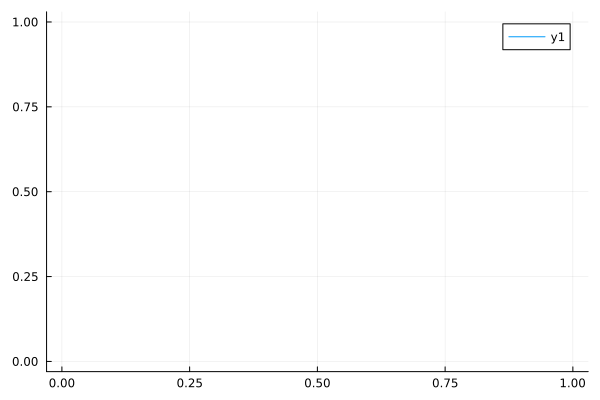

In [250]:
plot(list_loss_train)

In [137]:
sol_untrained = load("/home/tschala/research/LANL/testNODE/sol_learn_testNODE_untrained.jld2");

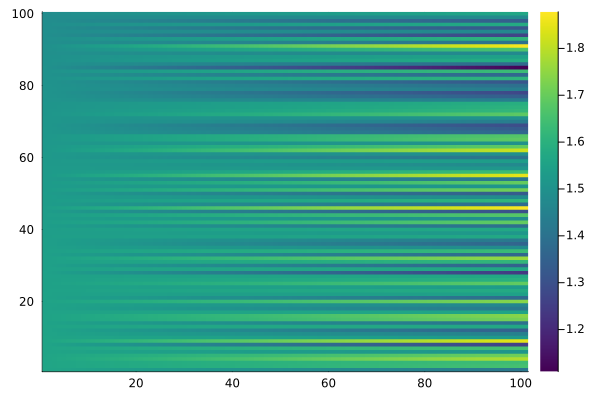

In [138]:
heatmap(sol_untrained["single_stored_object"], color=:viridis)

### Load the final learnt parameters and do inference ###

saved trained solution


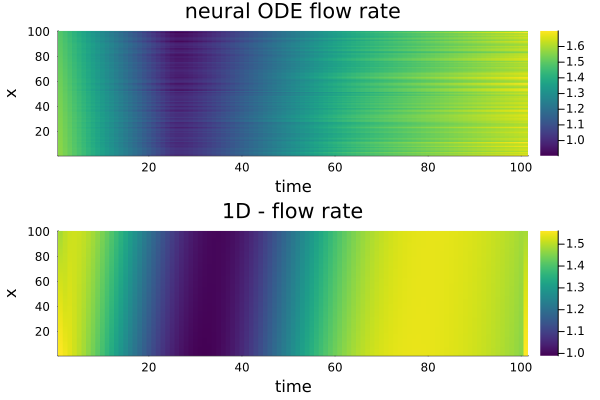

In [234]:
p_learn = load("/home/tschala/research/LANL/testNODE/ptrained_BFGS.jld2")
#waveform to evaluate
wv = 1
u01 = u0[:,wv]

begin 
    learn_1DBlood_prob_untrained(u01,tspan) = ODEProblem(learn_1DBlood, u01, tspan,p_learn["p"])     # p changes after training   
    if ode_solver == "Tsit5"
        sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Tsit5(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
    elseif ode_solver == "RK4"
        sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),RK4(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
    elseif ode_solver == "Rosenbrock23"
        sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Rosenbrock23(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
    end
    save_object(output_dir*"/sol_learn_testNODE_trained.jld2",sol_learn_1DBlood_untrained)
    println("saved trained solution")
end

sol_learn = load("/home/tschala/research/LANL/testNODE/output/sol_learn_testNODE_trained.jld2");

plot1 = heatmap(sol_learn["single_stored_object"][:,:], color=:viridis, title = "neural ODE flow rate")
xlabel!("time")
ylabel!("x")

plot2 = heatmap(ytrain2[:,:,wv]', title="1D - flow rate", color=:viridis)
xlabel!("time")
ylabel!("x")

plot(plot1,plot2,layout = (2, 1))

saved trained solution


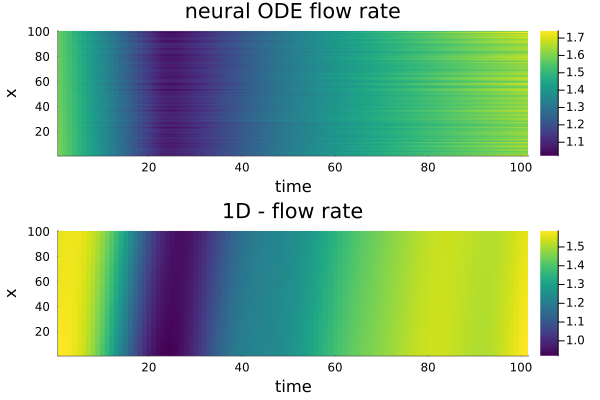

In [235]:
p_learn = load("/home/tschala/research/LANL/testNODE/ptrained_BFGS.jld2")
#waveform to evaluate
wv = 4
u01 = u0[:,wv]

begin 
    learn_1DBlood_prob_untrained(u01,tspan) = ODEProblem(learn_1DBlood, u01, tspan,p_learn["p"])     # p changes after training   
    if ode_solver == "Tsit5"
        sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Tsit5(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
    elseif ode_solver == "RK4"
        sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),RK4(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
    elseif ode_solver == "Rosenbrock23"
        sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Rosenbrock23(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
    end
    save_object(output_dir*"/sol_learn_testNODE_trained.jld2",sol_learn_1DBlood_untrained)
    println("saved trained solution")
end

sol_learn = load("/home/tschala/research/LANL/testNODE/output/sol_learn_testNODE_trained.jld2");

plot1 = heatmap(sol_learn["single_stored_object"][:,:], color=:viridis, title = "neural ODE flow rate")
xlabel!("time")
ylabel!("x")

plot2 = heatmap(ytrain2[:,:,wv]', title="1D - flow rate", color=:viridis)
xlabel!("time")
ylabel!("x")

plot(plot1,plot2,layout = (2, 1))